# Поведение пользователей мобильного приложения

 Разобраться как ведут себя пользователи в событийной модели. Исследование A/B теста по изменению дизайна мобольного приложния на трех группах экспериментальной и двух тестовых. 
 
 Версия в pdf по [сслыке](https://yadi.sk/i/k4fScnl23C8kKw) 

In [1]:
# подгружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats as st
from datetime import timedelta
from matplotlib import pyplot as plt

In [2]:
#Загрузим интересующиий нас датасет
df = pd.read_csv('/datasets/logs_exp.csv', delim_whitespace = 1)

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# Удалим дубликаты и проверим изменилась ли общее число строк
df.drop_duplicates()
df.shape

(244126, 4)

In [6]:
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [7]:
# Переименум колонки в удобные для чтения оставляя их смысл
df.columns = ['event','id','timestamp_event','group']

In [8]:
df.head()

,event,id,timestamp_event,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [9]:
# Добавим несколько новых столбцов - дата/время и агрегирующее поля для подсчетов. переменную id переведем в тип "строка"
df['date_time'] = pd.to_datetime(df['timestamp_event'], unit='s')
df['id'] = df['id'].astype('str')
df['aggregate'] = 1

In [10]:
# Добавим столбик с датой и временем
df['date'] = df['date_time'].astype('datetime64[D]')
df['time'] = df['date_time'].astype('datetime64[h]')
df['time'] = df['time'].astype('str')
df['time'] = df['time'].apply(lambda x: str(x)[-9:])

In [11]:
df.head()

,event,id,timestamp_event,group,date_time,aggregate,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,1,2019-07-25,04:00:00
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,1,2019-07-25,11:00:00
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,1,2019-07-25,11:00:00
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,1,2019-07-25,11:00:00
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,1,2019-07-25,11:00:00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 8 columns):
event              244126 non-null object
id                 244126 non-null object
timestamp_event    244126 non-null int64
group              244126 non-null int64
date_time          244126 non-null datetime64[ns]
aggregate          244126 non-null int64
date               244126 non-null datetime64[ns]
time               244126 non-null object
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 14.9+ MB


# Изучение полученных данных

In [13]:
# Узнаем сколько всего событий в логе
all_events = df.count()[0]
print(f'Всего событий в логе: {all_events}')

Всего событий в логе: 244126


In [14]:
# Функция будет считать уникальных пользователей в датасете
def count_uniq_id(df):
    list_id = df['id'].unique()
    count_uniq_id = len(list_id)
    return int(count_uniq_id)

In [15]:
list_id = count_uniq_id(df)
print(f'Всего уникальных идентификаторов:', list_id)

Всего уникальных идентификаторов: 7551


In [16]:
# Посчитаем сколько в среднем событий приходится на одного пользвателя
mean_per_user = df.pivot_table(values='aggregate', index='id', columns = 'event', aggfunc='sum')
mean_per_user = mean_per_user.fillna(0).reset_index()
mean_per_user['all_event'] = mean_per_user['CartScreenAppear'] + \
                                    mean_per_user['MainScreenAppear'] + \
                                        mean_per_user['OffersScreenAppear'] + \
                                                mean_per_user['PaymentScreenSuccessful'] + \
                                                    mean_per_user['Tutorial']

count_mean_ever_id = mean_per_user['all_event'].mean().round(2)
print(f'В среднем событий для пользователя: {count_mean_ever_id}')

В среднем событий для пользователя: 32.33


                         aggregate
event                             
MainScreenAppear            119205
OffersScreenAppear           46825
CartScreenAppear             42731
PaymentScreenSuccessful      34313
Tutorial                      1052


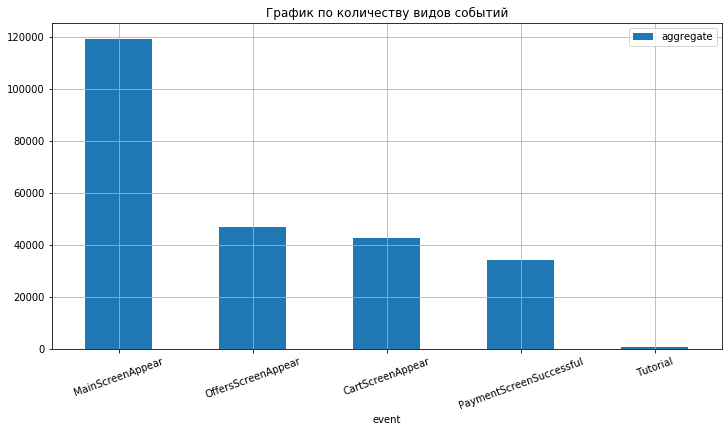

In [17]:
# Построим график чтобы выяснить общую воронку событий по численности
event_count = df.pivot_table(values='aggregate', index='event', aggfunc='sum')
event_count = event_count.sort_values('aggregate', ascending = False)
title_n = 'График по количеству видов событий'
event_count.plot.bar(figsize=(7, 5), title = title_n, grid = True);
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(rotation=20)
print(event_count)
plt.show()

### Выясним какие данные за какой период у нас есть как они распологаются на графике

In [18]:
df['date'].describe()

count                  244126
unique                     14
top       2019-08-01 00:00:00
freq                    36229
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: date, dtype: object

Из первоначального датасета видно, что мы распологаем данными примерно за месяц от 25 июля по 8 августа 2019 года

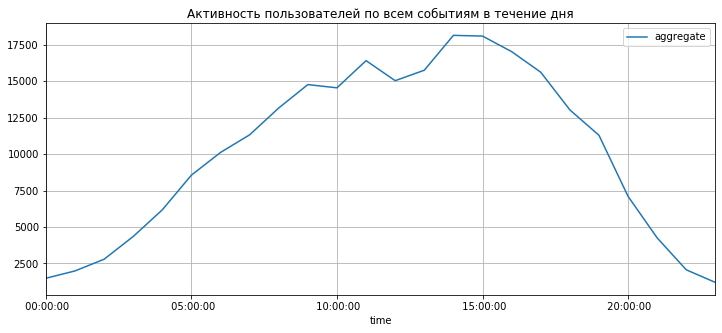

In [19]:
df_hist = df.pivot_table(index = 'time', values=['aggregate'], aggfunc='sum')

title_n = 'Активность пользователей по всем событиям в течение дня'
df_hist.plot(grid=True, figsize=(12, 5), title = title_n);

Смотрим активность пользователей по часам в течение суток и видим в полне понятный график. Заметим, что активность есть и ночью по этому события по своей хронологии моут съезжать в другую дату, что очень жаль. Хотелось бы идентификатор сессии.

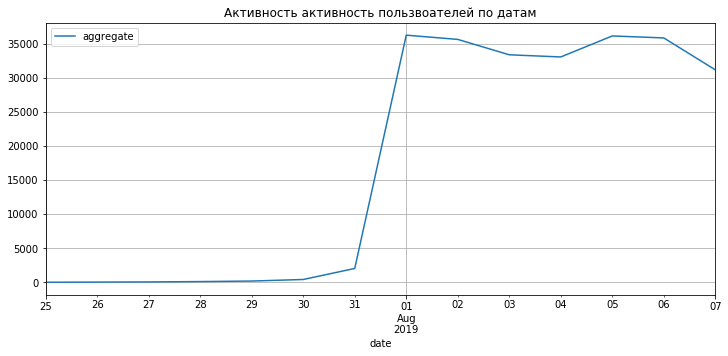

In [20]:
# Построим график активности пользоватлей по дням
df_hist = df.pivot_table(index = 'date', values=['aggregate'], aggfunc='sum')

title_n = 'Активность активность пользвоателей по датам'
df_hist.plot(grid=True, figsize=(12, 5), title = title_n);

График скорее всего показывает, что рабочий старат приложения состоялся 1 августа а до этого оно работало скорее всего в тестовом режиме.

In [21]:
df_garbage = df[(df['date'] < '2019-08-01')]
df_garbage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 0 to 2827
Data columns (total 8 columns):
event              2828 non-null object
id                 2828 non-null object
timestamp_event    2828 non-null int64
group              2828 non-null int64
date_time          2828 non-null datetime64[ns]
aggregate          2828 non-null int64
date               2828 non-null datetime64[ns]
time               2828 non-null object
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 198.8+ KB


Придется обрезать всего три тысяци событий, что не так много

In [22]:
#  обрезаем датафрейм по дате 
df = df[(df['date'] >= '2019-08-01')]
df.head()

,event,id,timestamp_event,group,date_time,aggregate,date,time
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,1,2019-08-01,00:00:00
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,1,2019-08-01,00:00:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,1,2019-08-01,00:00:00
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,1,2019-08-01,00:00:00
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,1,2019-08-01,00:00:00


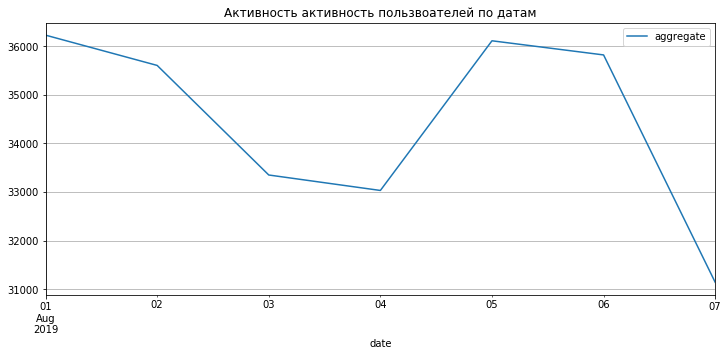

In [23]:
#  Строим график активности по очищенным датам
df_hist = df.pivot_table(index = 'date', values=['aggregate'], aggfunc='sum')

title_n = 'Активность активность пользвоателей по датам'
df_hist.plot(grid=True, figsize=(12, 5), title = title_n);

Констатируем, что данных для работы у нас ровно неделя.

In [24]:
df.head()

,event,id,timestamp_event,group,date_time,aggregate,date,time
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,1,2019-08-01,00:00:00
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,1,2019-08-01,00:00:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,1,2019-08-01,00:00:00
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,1,2019-08-01,00:00:00
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,1,2019-08-01,00:00:00


##### поделим датасеты на три группы для изучения


In [25]:
df_246 = df.query('group == 246')
df_247 = df.query('group == 247')
df_248 = df.query('group == 248')

In [26]:
group_a, group_b, group_c =  df_246.shape[0], df_247.shape[0], df_248.shape[0]

In [27]:
# Функция собирающая информацию по группе пользователей
def info_about_group(df_func, num_group):
    event_count = df_func.pivot_table(values='aggregate', index='event', aggfunc='sum')
    event_count = event_count.sort_values('aggregate', ascending = False)
    title_n = 'График по количеству видов событий'
    event_count.plot.bar(figsize=(7, 5), title = title_n, grid = True);
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    plt.xticks(rotation=20)
    
    #event_count.plot(kind='barh', title = title_n, grid = True);
            
    print('Количество событий')
    print(event_count)
    #plt.show()

    list_id = count_uniq_id(df_func)
    last_date_248, first_date_248 =  df_func['date'].max(),  df_func['date'].min()
    print()
    print(f'Экспериментальная группа номер {num_group} содержит : {group_c} события и {list_id} уникальных идентификатора')
    print(f'Первая событие датируется {first_date_248} и последнее {last_date_248}')

### Экспериментальная группа 248

Количество событий
                         aggregate
event                             
MainScreenAppear             40600
OffersScreenAppear           16395
CartScreenAppear             15198
PaymentScreenSuccessful      12160
Tutorial                       373

Экспериментальная группа номер 248 содержит : 84726 события и 2537 уникальных идентификатора
Первая событие датируется 2019-08-01 00:00:00 и последнее 2019-08-07 00:00:00


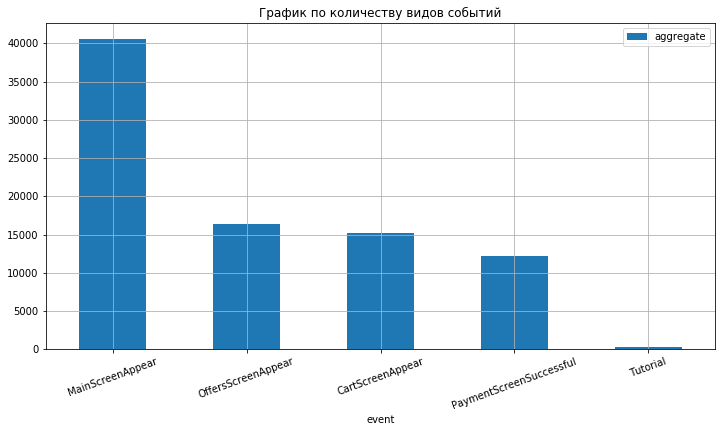

In [28]:
info_about_group(df_248, '248')

### Контрольная группа 246

Количество событий
                         aggregate
event                             
MainScreenAppear             37708
OffersScreenAppear           14773
CartScreenAppear             14711
PaymentScreenSuccessful      11910
Tutorial                       323

Экспериментальная группа номер 246 содержит : 84726 события и 2484 уникальных идентификатора
Первая событие датируется 2019-08-01 00:00:00 и последнее 2019-08-07 00:00:00


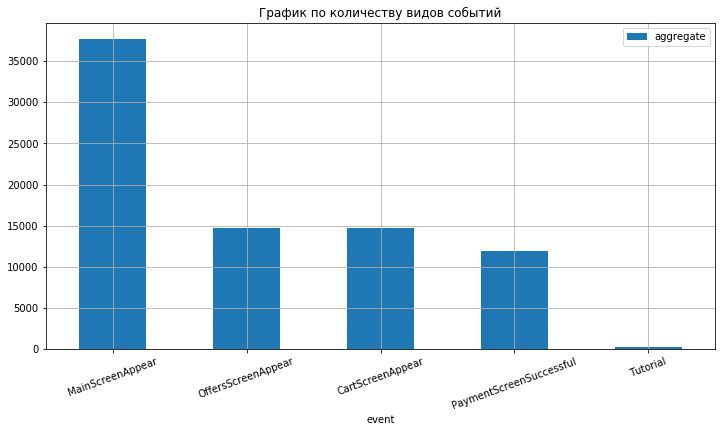

In [29]:
info_about_group(df_246, '246')

### Контрольная группа 247

Количество событий
                         aggregate
event                             
MainScreenAppear             39123
OffersScreenAppear           15182
CartScreenAppear             12456
PaymentScreenSuccessful      10043
Tutorial                       343

Экспериментальная группа номер 247 содержит : 84726 события и 2513 уникальных идентификатора
Первая событие датируется 2019-08-01 00:00:00 и последнее 2019-08-07 00:00:00


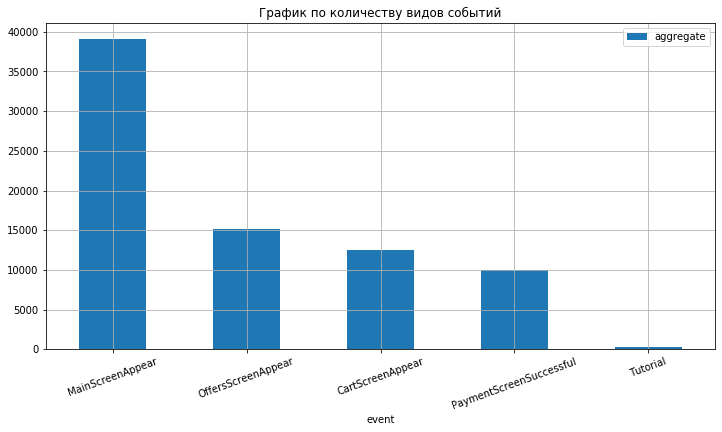

In [30]:
info_about_group(df_247, '247')

## Число пользователей, которые совершали каждое из событий.

In [31]:
even_user = df.pivot_table(values='aggregate', index='id', columns = 'event').fillna(0).reset_index()
even_user.head()

event,id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,1000608915523616548,0.0,1.0,1.0,0.0,0.0
1,100724994572555335,0.0,1.0,0.0,0.0,0.0
2,1008242126838007188,1.0,1.0,1.0,1.0,0.0
3,1009503747199967885,1.0,1.0,1.0,1.0,0.0
4,1009745980451513098,1.0,1.0,1.0,1.0,0.0


In [32]:
df_events_sum = even_user[['CartScreenAppear','MainScreenAppear','OffersScreenAppear'\
                                                           ,'PaymentScreenSuccessful','Tutorial']].sum().reset_index()

df_events_sum.columns = ['event', 'count']
df_events_sum = df_events_sum.set_index('event')

Количество событий
                          count
event                          
Tutorial                  840.0
PaymentScreenSuccessful  3539.0
CartScreenAppear         3734.0
OffersScreenAppear       4593.0
MainScreenAppear         7419.0


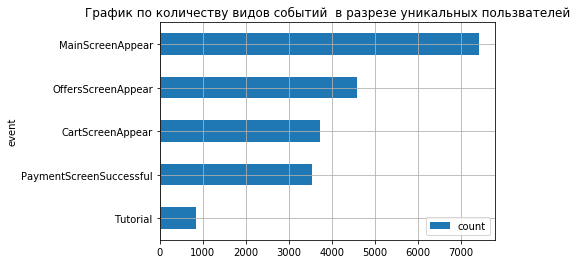

In [33]:
title_n = 'График по количеству видов событий  в разрезе уникальных пользвателей'
df_events_sum = df_events_sum.sort_values('count', ascending = True)

print('Количество событий')
print(df_events_sum)
df_events_sum.plot(kind='barh', title = title_n, grid = True);

In [34]:
# Функция которая узнает прошел ли все события пользвоатель или нет
def all_event(row):
    
    CartScreenAppear = row['CartScreenAppear']
    MainScreenAppear = row['MainScreenAppear']
    OffersScreenAppear = row['OffersScreenAppear']
    PaymentScreenSuccessful = row['PaymentScreenSuccessful']
    Tutorial = row['Tutorial']
    
    if CartScreenAppear > 0 and\
        MainScreenAppear > 0 and\
            OffersScreenAppear > 0 and\
                PaymentScreenSuccessful > 0 and\
                    Tutorial > 0:
        return True
    
    else:
        
        return False

In [35]:
# Вычисляет было ли хотябы одно событие
def just_one_event(row):
    
    CartScreenAppear = row['CartScreenAppear']
    MainScreenAppear = row['MainScreenAppear']
    OffersScreenAppear = row['OffersScreenAppear']
    PaymentScreenSuccessful = row['PaymentScreenSuccessful']
    Tutorial = row['Tutorial']
    
    event = CartScreenAppear + MainScreenAppear + OffersScreenAppear + PaymentScreenSuccessful + Tutorial
    
    if event == 1:
        return 1
    else:
        return 0

In [36]:
# Делаем цифру для того чтобы сравнивать датафреймы (просто плюсуем важные для нас события)
def sum_event(row):
    
    CartScreenAppear = row['CartScreenAppear']
    MainScreenAppear = row['MainScreenAppear']
    OffersScreenAppear = row['OffersScreenAppear']
    PaymentScreenSuccessful = row['PaymentScreenSuccessful']
    Tutorial = row['Tutorial']
    
    event = CartScreenAppear + MainScreenAppear + OffersScreenAppear + PaymentScreenSuccessful
    
    if event == 1:
        return 1
    else:
        return 0

In [37]:
even_user['all_event'] = even_user.apply(all_event, axis=1)
even_user['just_one_event'] = even_user.apply(just_one_event, axis=1)
even_user['sum_event'] = even_user.apply(just_one_event, axis=1)
even_user_all = even_user.query('just_one_event == 1')
one_even_id = even_user_all.count()[0]
print(f'Число пользователей совершивших хотябы одно событие : {one_even_id}')

Число пользователей совершивших хотябы одно событие : 2717


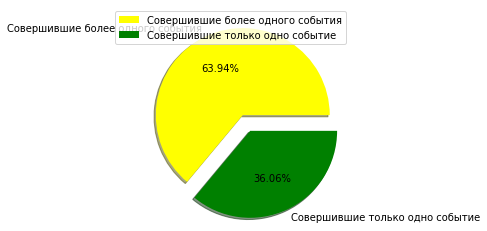

In [38]:
size = list(even_user['just_one_event'].value_counts().reset_index()['just_one_event'])
colors = ['yellow', 'green']
labels = "Совершившие более одного события", "Совершившие только одно событие"
explode = [0, 0.2]

plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%', explode = explode, shadow = True)
plt.legend()
plt.show()

## Последовательность событий

Если события последовательны, то для того чтобы предположить их последовательность достаточно взглянуть на гистограммы построенные выше. Очередность их идет по убыванию, и только для одного события можно сказать, что оно выходит и из этого графика - это tutorial. Если даже довереться переводу это это "руководство по эксплуатиции" которое скорее всего вызывается только в том случае когда человек не разобрался как ему рабоать с данной страницой или приложением.

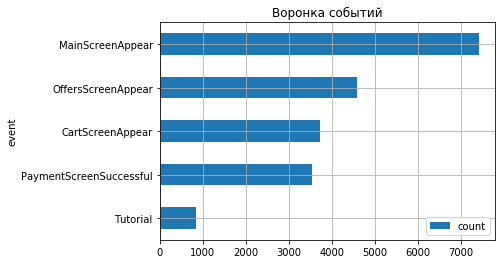

In [39]:
# Воронка событий количественному событию на пользователя
title_n = "Воронка событий"
df_events_sum.plot(kind='barh', title = title_n, grid = True);

Предположите, в какой последовательности события происходят в приложении. Все ли события выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

In [40]:
# Сформируем датасет в котором выделим для каждого пользователя действие и время в которое он его делал
df_next_event = df.pivot_table(values='aggregate', index=['id','date', 'time'], columns = 'event')\
                                                                            .fillna(0).reset_index()


# Выстроим воронку в сооттветствие с последовательностью в разрезе пользвоателя
df_next_event = df_next_event[['id', 'date','time','MainScreenAppear','OffersScreenAppear', 'CartScreenAppear'\
                                                                                           , 'PaymentScreenSuccessful']]

# Выведим первые 10 строк чтобы удостовериться
df_next_event.head(10)

event,id,date,time,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,1000608915523616548,2019-08-01,16:00:00,1.0,0.0,0.0,0.0
1,1000608915523616548,2019-08-07,16:00:00,1.0,1.0,0.0,0.0
2,100724994572555335,2019-08-05,16:00:00,1.0,0.0,0.0,0.0
3,1008242126838007188,2019-08-01,09:00:00,1.0,1.0,1.0,1.0
4,1008242126838007188,2019-08-02,07:00:00,1.0,1.0,1.0,1.0
5,1008242126838007188,2019-08-05,13:00:00,1.0,1.0,1.0,1.0
6,1009503747199967885,2019-08-04,16:00:00,1.0,1.0,0.0,0.0
7,1009503747199967885,2019-08-05,09:00:00,0.0,1.0,1.0,1.0
8,1009503747199967885,2019-08-05,10:00:00,0.0,1.0,0.0,0.0
9,1009503747199967885,2019-08-05,12:00:00,1.0,1.0,0.0,0.0


## Доля пользвотелей которая переходит на следующий шаг по данным всего датасета

Посчитаем конверсию для всего датасета по переходам на следующий значимый этап

In [41]:
# Содадим функцию которая можно будет давать датасет в нужном нам формате а она будет считать конверсию по продвижению по 
# приложению

def info_conv_step_by_step(df_fn):
    
    df_con = df_fn.pivot_table(values='aggregate', index='id', columns = 'event').fillna(0).reset_index()
    df_con = df_con[['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']]
    df_con = df_con.sum().reset_index()
    df_con.columns = ['event', 'count']
    count_main = df_con.loc[df_con['event'] == 'MainScreenAppear']['count'].max()
    count_offer = df_con.loc[df_con['event'] == 'OffersScreenAppear']['count'].max()
    count_cart = df_con.loc[df_con['event'] == 'CartScreenAppear']['count'].max()
    count_payment = df_con.loc[df_con['event'] == 'PaymentScreenSuccessful']['count'].max()
    df_con['conv'] = 0
    
    df_con.loc[0, 'conv'] = 100
    df_con.loc[1, 'conv'] = count_offer/count_main*100
    df_con.loc[2, 'conv'] = count_cart/count_offer*100
    df_con.loc[3, 'conv'] = count_payment/count_cart*100
    df_con['conv'] = df_con['conv'].round(2)
    
    return df_con

In [42]:
# Посчитаем конверсию для общей таблицы
df_con_all = info_conv_step_by_step(df)
df_con_all

,event,count,conv
0,MainScreenAppear,7419.0,100.00
1,OffersScreenAppear,4593.0,61.91
2,CartScreenAppear,3734.0,81.30
3,PaymentScreenSuccessful,3539.0,94.78


Больше всего пользователей теряется на главном экране так как конвесия перехода с этого экрана составляет всего 40 процентов.

In [43]:
# Конверся от первого к последнему экрану
df_con = df.pivot_table(values='aggregate', index='id', columns = 'event').fillna(0).reset_index()
df_con = df_con[['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']]
df_con = df_con.sum().reset_index()
df_con.columns = ['event', 'count']
count_payment = df_con.loc[df_con['event'] == 'PaymentScreenSuccessful']['count'].max()
count_main = df_con.loc[df_con['event'] == 'MainScreenAppear']['count'].max()

start_end = (count_payment/count_main*100).round(2)
print(f'Всего конверсия по пользователям которые заходят на главный экран и доходят до покупки составляет {start_end} %')

Всего конверсия по пользователям которые заходят на главный экран и доходят до покупки составляет 47.7 %


## Проверка гипотезы о равенстве двух контрольных групп 246 и 247

Для того чтобы сравнить две группы я прибегнул к такому критерию: Для каждого уникального пользователя я выбрал проходил ли он хотябы один раз каждое из событий и обозначил это цифрой 1 для того чтобы сравнить их по одному массиву я сложил 4 основных события и в итоге в столбце должно остаться цифра от 0 до 4. По этой совокупности мы и будем сравнивать группы.

In [44]:
even_user.head()

event,id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,all_event,just_one_event,sum_event
0,1000608915523616548,0.0,1.0,1.0,0.0,0.0,False,0,0
1,100724994572555335,0.0,1.0,0.0,0.0,0.0,False,1,1
2,1008242126838007188,1.0,1.0,1.0,1.0,0.0,False,0,0
3,1009503747199967885,1.0,1.0,1.0,1.0,0.0,False,0,0
4,1009745980451513098,1.0,1.0,1.0,1.0,0.0,False,0,0


In [45]:
# возьмем пользователей которые учавствуют в выборке по трем группам
list_is_246 = df_246["id"].unique().tolist()
list_is_247 = df_247["id"].unique().tolist()
list_is_248 = df_248["id"].unique().tolist()

In [46]:
# Посмотрим пересечения в группах, чтобы в две контрольные группы не попали одинкаовые пользователи
c = list(set(list_is_246) & set(list_is_247))
len(c)

0

In [47]:
# Сделаем три таблицы из выборок групп 246 247 248
even_user_246 = even_user.query('id in @list_is_246')
even_user_247 = even_user.query('id in @list_is_247')
even_user_248 = even_user.query('id in @list_is_248')

##### Нулевая гипотеза: Две контрольные группы 246 и 247 равнозначны по действиям пользователей

In [48]:
# Пояснения к методике были приведены обзацем темы, в остальном обычная проверка с уровнем 0.05

array_246 = even_user_246['sum_event'].tolist()
array_247 = even_user_246['sum_event'].tolist()

alpha_set = .05   # критический уровень статистической значимости
                  # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    array_246, 
    array_247, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_set):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


Действительно, пользователи из этих двух групп ведут по составу событий одинаковы. т.е. две совокупности были на похожем количемстве событий датасета

### Проверить могут ли быть статистические данные между группа достоверными

Сперва построим таблицу конверсии по предъидущим этапам для двух контрольных групп. Очевидно, что самое популярное событие будет главный экран.

Из таблиц конверсии и числу пользователей которые видели конкретное событие мы можем сказать, что выборки очень похожи и для того чтобы выявить в них статистическую разницу во-первых снизим показатель статиситеческой значимости до 1%. и тут есть Разделение для выяснения равенства групп мы можем датасеты подготовить поразному: с всеми событиями, когда один пользователь заходил на главный экран 30 раз и дальше не проходил или по факту когда в разрезе пользователь и сколько экранов видел этот пользователь. Более правильным мне кажется второй вариант так как он ближе к сути бизнеса а именно когда n-ое количество человек дошло до экрана опралаты и не имеет значения сколько раз до этого он сомотрел на главный экран.  Первый вариант тоже не лишен смысла если мы хотим провести более подробное исследование поведенческих патернов аудитории и как можно скоротать время прохождения человека между экранами к самому главному - с оплатой. Но для второго исследования потребуется больше данных для выясненния причин почему человек часто заходит на главную но не продвигается дальше.

##### Конверсия для контрольной группы 246

In [49]:
df_con_246 = info_conv_step_by_step(df_246)
df_con_246

,event,count,conv
0,MainScreenAppear,2450.0,100.00
1,OffersScreenAppear,1542.0,62.94
2,CartScreenAppear,1266.0,82.10
3,PaymentScreenSuccessful,1200.0,94.79


##### Конверсия для контрольной группы 247

In [50]:
df_con_247 = info_conv_step_by_step(df_247)
df_con_247

,event,count,conv
0,MainScreenAppear,2476.0,100.00
1,OffersScreenAppear,1520.0,61.39
2,CartScreenAppear,1238.0,81.45
3,PaymentScreenSuccessful,1158.0,93.54


### Проверка гипотез

Мы будем сравнивать группы по всем событиям отдельно и для этого напишим функцию а так как результат статистической значимости мы приняли за 0.1 то n-ое количество одного и того же эксперимента может привести к разным результатам.

##### Нулевая гипотеза: Выборки 246 и 247 по каждому событию равны

In [51]:
def make_array_great_again(ar):
    
    array = ar.tolist()
    
    return array  

In [52]:
def check_statistic_important(ar_1,ar_2,alfa):
    
    array_1 = make_array_great_again(ar_1)
    array_2 = make_array_great_again(ar_2)
    
    alpha_set = alfa   # критический уровень статистической значимости
                       # если p-value окажется меньше него - отвергнем гипотезу
    
    results = st.ttest_ind(
        array_1, 
        array_2, equal_var = False)
    
    print('p-значение:', results.pvalue)
    
    if (results.pvalue < alpha_set):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [53]:
check_statistic_important(even_user_246['MainScreenAppear'],even_user_247['MainScreenAppear'],.01)
check_statistic_important(even_user_246['OffersScreenAppear'],even_user_247['OffersScreenAppear'],.01)
check_statistic_important(even_user_246['CartScreenAppear'],even_user_247['CartScreenAppear'],.01)
check_statistic_important(even_user_246['PaymentScreenSuccessful'],even_user_247['PaymentScreenSuccessful'],.01)

p-значение: 0.7570684016388866
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.24816145871804243
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.2289162655301648
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.11461763081212137
Не получилось отвергнуть нулевую гипотезу


Несколько замеров дало одинковый результат, о чем можно сказать, что разница между выборками не более 1%. Статистическая значимость между группа ровна между собой. Хороший реультат для теста А/А

## Аналагично проверим две контрольные группы с тестовой

Сравним все три группы между собой 

In [54]:
def check_test_three_group(ar_1,ar_2,ar_3,alfa):
    
        sample_246 = make_array_great_again(ar_1)
        sample_247 = make_array_great_again(ar_2)
        sample_248 = make_array_great_again(ar_3)
        
        alpha = alfa # критический уровень статистической значимости

        results_246_247 = st.ttest_ind(
            sample_246, 
            sample_247)

        results_247_248 = st.ttest_ind(
            sample_247, 
            sample_248)

        results_246_248 = st.ttest_ind(
            sample_246, 
            sample_248)

        bonferroni_alpha = alpha / 3  # произведено три сравнения

        print('p-значение для сравнения групп 246 и 247: ', results_246_247.pvalue)
        print('p-значение для сравнения групп 247 и 248: ', results_247_248.pvalue)
        print('p-значение для сравнения групп 246 и 248: ', results_246_248.pvalue)

        if (results_246_247.pvalue < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
        else:
            print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

        if (results_247_248.pvalue < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
        else:
            print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

        if (results_246_248.pvalue < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
        else:
            print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

##### Нулевая гипотеза для всех групп: группы имееют одинаковую статестическую значимость.

In [55]:
check_test_three_group(even_user_246['MainScreenAppear']\
                       ,even_user_247['MainScreenAppear'],even_user_248['MainScreenAppear'],.05)    

p-значение для сравнения групп 246 и 247:  0.7571174621103072
p-значение для сравнения групп 247 и 248:  0.45880437959723175
p-значение для сравнения групп 246 и 248:  0.29506606465679136
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


In [56]:
check_test_three_group(even_user_246['OffersScreenAppear']\
                       ,even_user_247['OffersScreenAppear'],even_user_248['OffersScreenAppear'],.05)    

p-значение для сравнения групп 246 и 247:  0.248182234448679
p-значение для сравнения групп 247 и 248:  0.9198015341631126
p-значение для сравнения групп 246 и 248:  0.20843948636199391
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


In [57]:
check_test_three_group(even_user_246['CartScreenAppear']\
                       ,even_user_247['CartScreenAppear'],even_user_248['CartScreenAppear'],.05)   

p-значение для сравнения групп 246 и 247:  0.22891646330485427
p-значение для сравнения групп 247 и 248:  0.5787080147829398
p-значение для сравнения групп 246 и 248:  0.07845751752267907
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


In [58]:
check_test_three_group(even_user_246['PaymentScreenSuccessful']\
                       ,even_user_247['PaymentScreenSuccessful'],even_user_248['PaymentScreenSuccessful'],.05)

p-значение для сравнения групп 246 и 247:  0.11461233163248476
p-значение для сравнения групп 247 и 248:  0.7374027184332623
p-значение для сравнения групп 246 и 248:  0.2123337471133262
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


Я думал, что придется делать таблицу с числом отвергнутых и принятых гипотез но все показатели говорят, что пользователи одинаковы. Все 12 тестов показали приоритет нулевой гипотезы.

### Сравним результаты с объединенной контрольной группой.

In [59]:
all_list_test = list_is_246 + list_is_247
even_user_246_247 = even_user.query('id in @all_list_test')
even_user_246_247.head()

event,id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,all_event,just_one_event,sum_event
0,1000608915523616548,0.0,1.0,1.0,0.0,0.0,False,0,0
1,100724994572555335,0.0,1.0,0.0,0.0,0.0,False,1,1
2,1008242126838007188,1.0,1.0,1.0,1.0,0.0,False,0,0
5,1010439893181060015,0.0,1.0,0.0,0.0,0.0,False,1,1
6,1011982461038688201,1.0,1.0,1.0,1.0,0.0,False,0,0


##### Нулевая гипотеза: Выборки тестовой группы и объединенной контрольной равны.

In [60]:
check_statistic_important(even_user_248['MainScreenAppear'],even_user_246_247['MainScreenAppear'],.05)
check_statistic_important(even_user_248['OffersScreenAppear'],even_user_246_247['OffersScreenAppear'],.05)
check_statistic_important(even_user_248['CartScreenAppear'],even_user_246_247['CartScreenAppear'],.05)
check_statistic_important(even_user_248['PaymentScreenSuccessful'],even_user_246_247['PaymentScreenSuccessful'],.05)

p-значение: 0.3097822989169634
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.4349818070597422
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.1817731027550196
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.6004101464514461
Не получилось отвергнуть нулевую гипотезу


В всех трех случаях не удалось опровергнуть нулевую гипотезу. Делаем вывод, что статистического отличия между выборками нет. Уровень статистической значимсти 0.05

***Вывод:*** Для воронки продаж мобильного приложения было взято четыре основных события: главный экран, раздел предложений, корзина и экран успешной оплаты. Конверся показала, что самый плохой показатель между главным экраном и разделом предложений, дальше конверсия не падает меньше 20%. Можно обратить внимание на молую долю между корзиной и экраном оплаты. Эти же цифры и подтверждает доля человек которые сделали только одно событие и так как если они последовтельны очевидно, что это главный экран. Доля таких пользователей 39%. Для A/B теста который проходил в мобильном приложение было сделано 18 тестов. Нулевой гипотезой выдвигалась теория о статестическом равенстве выборок мжеду двумя контрольным игруппами и тестовой. Уровень статестической значимости был равен 0,05. Не одна гипотеза не показала отличия в выборках.